In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

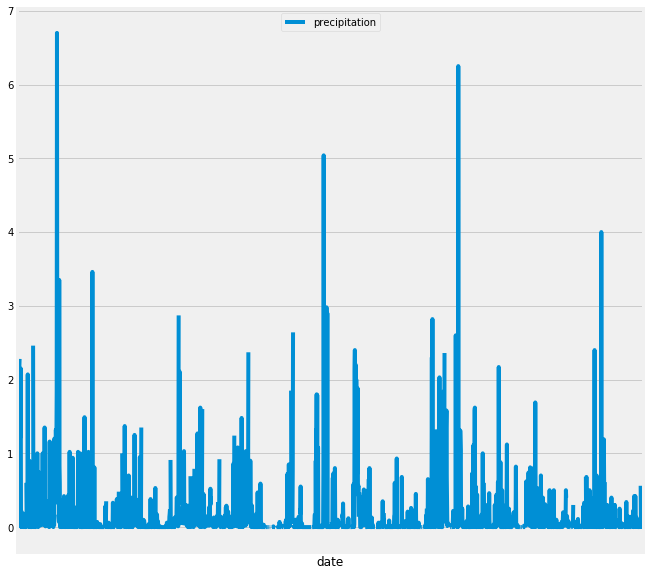

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

maxdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#maxdate

max_date = dt.date(2017, 8, 23)

# Calculate the date 1 year ago from the last data point in the database
year_ago = max_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores

query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

    
# Save the query results as a Pandas DataFrame and set the index to the date column

percp_dp = pd.DataFrame(query,columns=['date', 'precipitation']).set_index("date")

# Sort the dataframe by date

precipitation_dp = percp_dp.sort_values(["date"], ascending = True)
precipitation_dp.head()

# Use Pandas Plotting with Matplotlib to plot the data


precipitation_dp.plot(figsize = (10, 10))
plt.xticks([])
plt.legend(loc = "upper center")
plt.show()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_dp.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).distinct(Station.name).count()


9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stat_all=[Measurement.station,func.count(Measurement.station),func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
stations_nums=session.query(stat_all[0],stat_all[1]).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_nums


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(stat_all[2],stat_all[3],stat_all[4]).filter(Measurement.station=='USC00519281').group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stat_hlast_year = session.query(
    Measurement.tobs)\
    .filter(Measurement.date>'2016-08-23')\
    .filter(Measurement.station=='USC00519281')\
    .all()


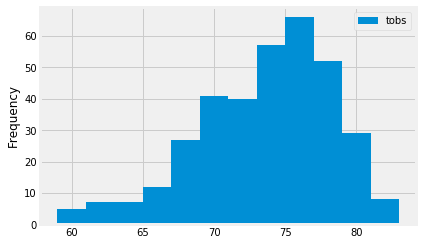

In [22]:
df = pd.DataFrame(stat_hlast_year,columns=['tobs'])
df.plot.hist(bins=12)
#plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date=input("input start date as YYYY-MM-DD")
end_date=input("input end date as YYYY-MM-DD")

input start date as YYYY-MM-DD2012-02-28
input end date as YYYY-MM-DD2012-03-05


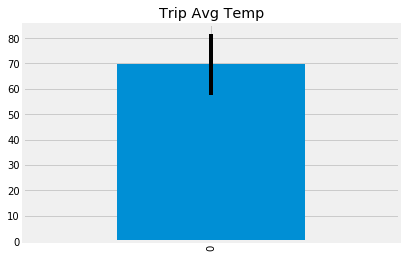

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp=calc_temps(start_date, end_date)
tript_dp = pd.DataFrame(trip_temp,columns=['Min', 'Avg','Max'])
tript_dp["Yerr"]=tript_dp.Max-tript_dp.Min
trip_temp_date=tript_dp[["Avg","Yerr"]]

trip_temp_date.plot.bar(legend=False,yerr="Yerr")
#plt.xticks([])
plt.title("Trip Avg Temp")

plt.show()

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_fall=session.query(Measurement.station,func.sum(Measurement.prcp)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.station.desc()).all()
total_fall

#.order_by(func.sum(Measurement.prcp).desc())

[('USC00519523', 2.92),
 ('USC00519397', 1.1800000000000002),
 ('USC00519281', 11.08),
 ('USC00518838', 3.8400000000000003),
 ('USC00517948', 0.0),
 ('USC00516128', 10.32),
 ('USC00514830', 0.03),
 ('USC00513117', 5.79),
 ('USC00511918', 0.76)]

In [31]:
stats=session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.station.desc()).all() 
stats

[('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  26.280000000000005),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  10.620000000000001),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  99.71999999999998),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  34.56000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  92.88000000000004),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.27),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  52.11000000000001),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  6.840000000000001)]

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
